In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
torch.manual_seed(0)

In [3]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [4]:
tokens_a = ['today', 'is', 'a', 'good', 'day']
tokens_b = ['well', 'done']
tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
print(f'tokens: {tokens}')
print(f'segments: {segments}')

tokens: ['<cls>', 'today', 'is', 'a', 'good', 'day', '<sep>', 'well', 'done', '<sep>']
segments: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]


In [5]:
class BERTEncoder(nn.Module):
    """BERT encoder."""

    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

ffn: positionwise feed-forward network

### Embeddings of the BERT input sequence
1. token embeddings
2. segment embeddings
3. **learnable** positional embeddings

### Input representation

In [6]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                      num_blks, dropout)

batch_size = 2
bert_input_len = 8
tokens = torch.randint(0, vocab_size, (batch_size, bert_input_len))

segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)

C:\Users\billt\PycharmProjects\DeepLearning\dl_venv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
tokens

tensor([[3049, 6983, 4325, 6814, 7680,  672, 8152, 4751],
        [1269, 9843, 3785, 5036, 7697, 9468, 9630, 8194]])

In [8]:
encoder.pos_embedding.shape

torch.Size([1, 1000, 768])

- tokens.shape: torch.Size([2, 8])
- X shape after token_embedding and segment_embedding: torch.Size([2, 8, 768])
- **broadcast** in ```X + self.pos_embedding[:, :X.shape[1], :]```: (a) self.pos_embedding is a tensor with shape: torch.Size([1, 1000, 768]) (b) when add pos_embedding onto ```X```, we keep the 1st and the last dimensions fixed, and extract the rows based on the input sequence length: self.pos_embedding[:, :X.shape[1], :].shape: torch.Size([1, 8, 768])

### Pretraining Task 1: Masked Language Modeling

BERT randomly masks tokens and uses tokens from the **bidirectional context** to predict the masked tokens in a self-supervised fashion. This task is referred to as a **masked language model**.

In [9]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""

    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [10]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
print(f'mlm_Y_hat.shape: {mlm_Y_hat.shape}')

mlm_Y_hat.shape: torch.Size([2, 3, 10000])


- X.shape: torch.Size([2, 8, 768])
- num_pred_positions: 3
- pred_positions: tensor([1, 5, 2, 6, 1, 5])
- batch_idx: tensor([0, 1])
- repeat_interleave batch_idx: tensor([0, 0, 0, 1, 1, 1])
- reshape masked_X.shape: torch.Size([2, 3, 768])
- ```mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])``` <font color='red'>For each batch, we randomly mask 3 tokens</font>.

Calculate the cross-entropy loss of the masked language model task in BERT pretraining.

In [11]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))

In [12]:
mlm_l

tensor([10.0247,  9.1743,  9.2157,  8.9047,  9.4068,  9.9162],
       grad_fn=<NllLossBackward0>)

### Pretraining Task 2:Next Sentence Prediction

In [13]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [14]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)

In [15]:
nsp_Y_hat

tensor([[ 0.2352, -0.5250],
        [ 0.0884, -0.1712]], grad_fn=<AddmmBackward0>)

- nsp_Y_hat has shape: (batch size, `num_hiddens`), here num_hiddens is 2 from ```self.output = nn.LazyLinear(2)```

In [16]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)

In [17]:
nsp_l

tensor([0.3836, 0.8313], grad_fn=<NllLossBackward0>)

### Putting It All Together

When pretraining BERT, the <font color='red'>final loss function</font> is a linear combination of both the loss functions
for masked language modeling and next sentence prediction

In [18]:
class BERTModel(nn.Module):
    """The BERT model."""

    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

1. ```encoded_X[:, 0, :]```, the encodded <CLS> token that <font color='red'>representes the encoded input sequence</font>. Due to self-attention
in the Transformer encoder, the BERT representation of the special token <cls> encodes both the two sentences from the input.

### Pretraining BERT

In [19]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * \
            mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [20]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                                                   pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.657, NSP loss 0.615
201.8 sentence pairs/sec on [device(type='cuda', index=0)]


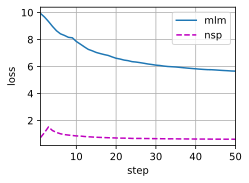

In [21]:
batch_size, max_len = 32, 16
num_steps = 50

train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

net = d2l.BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

train_bert(train_iter, net, loss, len(vocab), devices, num_steps)

1. max_len: the maximum length of a BERT input sequence

### Representing Text with BERT

In [23]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [24]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.2761,  1.5503, -1.1667], device='cuda:0', grad_fn=<SliceBackward0>))

In [25]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 0.2709,  1.8040, -1.3399], device='cuda:0', grad_fn=<SliceBackward0>))

1. The first three elements of the polysemy token "crane" are different from those when the context is different.
2. BERT representations are context-sensitive.